In [24]:
import jax
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
import matplotlib.pyplot as plt

In [2]:
model = nn.Dense(features=5)

In [30]:
key1, key2 = random.split(random.PRNGKey(0))
x = random.normal(key1, (10, ))
params = model.init(key2, x)

jax.tree_map(lambda x: x.shape, params)

FrozenDict({
    params: {
        bias: (5,),
        kernel: (10, 5),
    },
})

In [4]:
try:
    params['new_key'] = jnp.ones((2,2))
except ValueError as e:
    print("Error: ", e)

Error:  FrozenDict is immutable.


In [5]:
model.apply(params, x)

DeviceArray([-0.7358945 ,  1.3583757 , -0.79768723,  0.8168597 ,
              0.6297792 ], dtype=float32)

In [9]:
nsamples = 20
xdim = 10
ydim = 5

key = random.PRNGKey(0)
k1, k2 = random.split(key)
W = random.normal(k1, (xdim, ydim))
b = random.normal(k2, (ydim, ))
true_params = freeze({"params": {"bias": b, "kernel": W}})

ksample, knoise = random.split(k1)
x_samples = random.normal(ksample, (nsamples, xdim))
y_samples = jnp.dot(x_samples, W) + b
y_samples += 0.1 * random.normal(knoise, (nsamples, ydim))
print(x_samples.shape, y_samples.shape)

(20, 10) (20, 5)


In [19]:
def make_mse_func(x_batched, y_batched):
    def mse(params):
        def squared_error(x, y):
            y_pred = model.apply(params, x)
            return jnp.inner(y - y_pred, y - y_pred) / 2.0
        return jnp.mean(jax.vmap(squared_error)(x_batched, y_batched), axis=0)
    return jax.jit(mse)

loss = make_mse_func(x_samples, y_samples)

In [20]:
print(loss)

<CompiledFunction of <function make_mse_func.<locals>.mse at 0x7f6fe47b6160>>


In [36]:
alpha = 0.3
print("Loss for true W, b:", loss(true_params))
grad_fn = jax.value_and_grad(loss)
print(grad_fn)

for i in range(11):
    loss_val, grads = grad_fn(params)
    params = jax.tree_multimap(lambda x, y: x - alpha * y, params, grads)
    
    if i % 10 == 0:
        print("loss step {}: ".format(i), loss_val)

Loss for true W, b: 0.02363978
<function make_mse_func.<locals>.mse at 0x7f6fc6a0f820>
loss step 0:  0.07937195
loss step 10:  0.030525435


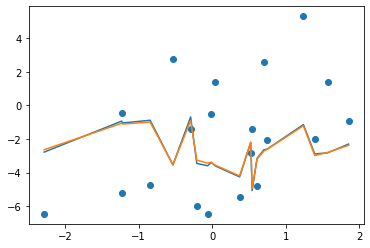

In [37]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.scatter(x_samples[:, 0], y_samples[:, 0])
ax.plot(jnp.sort(x_samples[:, 0]), model.apply(true_params, jnp.sort(x_samples))[:, 0])
ax.plot(jnp.sort(x_samples[:, 0]), model.apply(params, jnp.sort(x_samples))[:, 0])

In [39]:
import optax
tx = optax.sgd(learning_rate=alpha)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

In [48]:
for i in range(101):
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)  # updates are just (- alpha * grads) in this case
    params = optax.apply_updates(params, updates)
    
    if i % 10 == 0:
        print("loss", i, loss_val)

loss 0 0.0115685435
loss 10 0.011568409
loss 20 0.011568367
loss 30 0.011568333
loss 40 0.011568352
loss 50 0.0115683405
loss 60 0.011568342
loss 70 0.011568336
loss 80 0.01156834
loss 90 0.011568329
loss 100 0.011568353


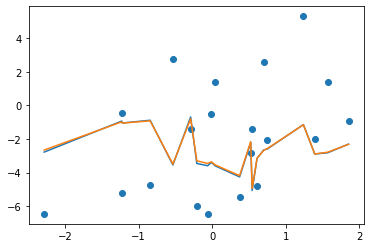

In [49]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.scatter(x_samples[:, 0], y_samples[:, 0])
ax.plot(jnp.sort(x_samples[:, 0]), model.apply(true_params, jnp.sort(x_samples))[:, 0])
ax.plot(jnp.sort(x_samples[:, 0]), model.apply(params, jnp.sort(x_samples))[:, 0])

# Serializing the result

In [50]:
from flax import serialization
bytes_output = serialization.to_bytes(params)
dict_output = serialization.to_state_dict(params)
print("dict output")
print(dict_output)
print("bytes output")
print(bytes_output)

dict output
{'params': {'bias': DeviceArray([-1.4540128 , -2.0262284 ,  2.0806592 ,  1.2201834 ,
             -0.99645793], dtype=float32), 'kernel': DeviceArray([[ 1.0106653 ,  0.19014455,  0.0453378 , -0.9272261 ,
               0.34720412],
             [ 1.732027  ,  0.99012953,  1.1662257 ,  1.1027969 ,
              -0.10575373],
             [-1.2009131 ,  0.28837103,  1.4176371 ,  0.12073033,
              -1.3132594 ],
             [-1.1944951 , -0.18993154,  0.03379178,  1.316596  ,
               0.07995883],
             [ 0.14103432,  1.373805  , -1.3162088 ,  0.5340287 ,
              -2.2396483 ],
             [ 0.56430596,  0.81360954,  0.31888452,  0.5359262 ,
               0.9035147 ],
             [-0.37948105,  1.7408428 ,  1.0788049 , -0.5041871 ,
               0.9286833 ],
             [ 0.97013843, -1.3158668 ,  0.33630848,  0.80941194,
              -1.2024575 ],
             [ 1.0198245 , -0.6198281 ,  1.0822716 , -1.8385587 ,
              -0.4579067 ],
    

In [51]:
serialization.from_bytes(params, bytes_output)

FrozenDict({
    params: {
        bias: array([-1.4540128 , -2.0262284 ,  2.0806592 ,  1.2201834 , -0.99645793],
              dtype=float32),
        kernel: array([[ 1.0106653 ,  0.19014455,  0.0453378 , -0.9272261 ,  0.34720412],
               [ 1.732027  ,  0.99012953,  1.1662257 ,  1.1027969 , -0.10575373],
               [-1.2009131 ,  0.28837103,  1.4176371 ,  0.12073033, -1.3132594 ],
               [-1.1944951 , -0.18993154,  0.03379178,  1.316596  ,  0.07995883],
               [ 0.14103432,  1.373805  , -1.3162088 ,  0.5340287 , -2.2396483 ],
               [ 0.56430596,  0.81360954,  0.31888452,  0.5359262 ,  0.9035147 ],
               [-0.37948105,  1.7408428 ,  1.0788049 , -0.5041871 ,  0.9286833 ],
               [ 0.97013843, -1.3158668 ,  0.33630848,  0.80941194, -1.2024575 ],
               [ 1.0198245 , -0.6198281 ,  1.0822716 , -1.8385587 , -0.4579067 ],
               [-0.6438426 ,  0.4564916 , -1.1331043 , -0.68556553,  0.1701061 ]],
              dtype=float32

# Defining your own models

In [59]:
class ExplicitMLP(nn.Module):
    features: Sequence[int]
    
    def setup(self):
        self.layers = [nn.Dense(feat) for feat in self.features]
    
    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)  # Apparently the parameters are internally set first by .apply(), this cannot be called from outside.
            if i != len(self.layers) - 1:
                x = nn.relu(x)
        return x

key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (4, 4))

model = ExplicitMLP(features=[3, 4, 5])
params = model.init(key2, x)
y = model.apply(params, x)

print('initialized parameter shapes:\n', jax.tree_map(jnp.shape, unfreeze(params)))
print('output:\n', y)

initialized parameter shapes:
 {'params': {'layers_0': {'bias': (3,), 'kernel': (4, 3)}, 'layers_1': {'bias': (4,), 'kernel': (3, 4)}, 'layers_2': {'bias': (5,), 'kernel': (4, 5)}}}
output:
 [[ 4.2292755e-02 -4.3807041e-02  2.9323744e-02  6.5492424e-03
  -1.7147157e-02]
 [ 1.2967803e-01 -1.4551784e-01  9.4432138e-02  1.2521380e-02
  -4.5417283e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 9.3024079e-04  2.7864418e-05  2.4478836e-04  8.1344321e-04
  -1.0110774e-03]]


In [61]:
try:
    y = model(x) # Returns an error
except AttributeError as e:
    print(e)

"ExplicitMLP" object has no attribute "layers"


In [70]:
class SimpleMLP(nn.Module):
    features: Sequence[int]
    
    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for i , feat in enumerate(self.features):
            x = nn.Dense(feat, name=f"layers_{i}")(x)
            if i != len(self.features) - 1:
                x = nn.relu(x)
        return x

key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key2, (4, 4))

model = SimpleMLP(features=[3, 4, 5])
params = model.init(key2, x)
y = model.apply(params, x)

print('initialized parameter shapes:\n', jax.tree_map(jnp.shape, unfreeze(params)))
print('output:\n', y)

initialized parameter shapes:
 {'params': {'layers_0': {'bias': (3,), 'kernel': (4, 3)}, 'layers_1': {'bias': (4,), 'kernel': (3, 4)}, 'layers_2': {'bias': (5,), 'kernel': (4, 5)}}}
output:
 [[ 0.00968247 -0.01002915  0.00671335  0.00149938 -0.00392566]
 [ 0.11862263 -0.12286989  0.08224718  0.0183693  -0.04809431]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]


# Module parameters

In [71]:
class SimpleDense(nn.Module):
    features: int
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros
    
    @nn.compact
    def __call__(self, inputs):
        kernel = self.param("kernel",
                            self.kernel_init,
                            (inputs.shape[-1], self.features))
        y = lax.dot_general(inputs, kernel,
                            (((inputs.ndim - 1, ), (0, )), ((), ())), )
        bias = self.param("bias", self.bias_init, (self.features, ))
        y = y + bias
        return y

key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (4, 4))

model = SimpleDense(features=3)
params = model.init(key2, x)
y = model.apply(params, x)

print('initialized parameters:\n', params)
print('output:\n', y)

initialized parameters:
 FrozenDict({
    params: {
        kernel: DeviceArray([[ 0.6503669 ,  0.8678977 ,  0.4604268 ],
                     [ 0.05673932,  0.99092865, -0.63536596],
                     [ 0.76134115, -0.3250529 , -0.65221626],
                     [-0.82430327,  0.4150194 ,  0.19405054]], dtype=float32),
        bias: DeviceArray([0., 0., 0.], dtype=float32),
    },
})
output:
 [[ 0.5035518   1.8548558  -0.42701954]
 [ 0.0279097   0.5589246  -0.43061775]
 [ 0.35471284  1.5740999  -0.32865518]
 [ 0.52648634  1.2928857   0.10089307]]


# Variables and collections of variables

In [72]:
class BiasAdderWithRunningMean(nn.Module):
  decay: float = 0.99

  @nn.compact
  def __call__(self, x):
    # easy pattern to detect if we're initializing via empty variable tree
    is_initialized = self.has_variable('batch_stats', 'mean')
    ra_mean = self.variable('batch_stats', 'mean',
                            lambda s: jnp.zeros(s),
                            x.shape[1:])
    mean = ra_mean.value # This will either get the value or trigger init
    bias = self.param('bias', lambda rng, shape: jnp.zeros(shape), x.shape[1:])
    if is_initialized:
      ra_mean.value = self.decay * ra_mean.value + (1.0 - self.decay) * jnp.mean(x, axis=0, keepdims=True)

    return x - ra_mean.value + bias


key1, key2 = random.split(random.PRNGKey(0), 2)
x = jnp.ones((10,5))
model = BiasAdderWithRunningMean()
variables = model.init(key1, x)
print('initialized variables:\n', variables)
y, updated_state = model.apply(variables, x, mutable=['batch_stats'])
print('updated state:\n', updated_state)

initialized variables:
 FrozenDict({
    batch_stats: {
        mean: DeviceArray([0., 0., 0., 0., 0.], dtype=float32),
    },
    params: {
        bias: DeviceArray([0., 0., 0., 0., 0.], dtype=float32),
    },
})
updated state:
 FrozenDict({
    batch_stats: {
        mean: DeviceArray([[0.01, 0.01, 0.01, 0.01, 0.01]], dtype=float32),
    },
})


In [73]:
for val in [1.0, 2.0, 3.0]:
  x = val * jnp.ones((10,5))
  y, updated_state = model.apply(variables, x, mutable=['batch_stats'])
  old_state, params = variables.pop('params')
  variables = freeze({'params': params, **updated_state})
  print('updated state:\n', updated_state) # Shows only the mutable part

updated state:
 FrozenDict({
    batch_stats: {
        mean: DeviceArray([[0.01, 0.01, 0.01, 0.01, 0.01]], dtype=float32),
    },
})
updated state:
 FrozenDict({
    batch_stats: {
        mean: DeviceArray([[0.0299, 0.0299, 0.0299, 0.0299, 0.0299]], dtype=float32),
    },
})
updated state:
 FrozenDict({
    batch_stats: {
        mean: DeviceArray([[0.059601, 0.059601, 0.059601, 0.059601, 0.059601]], dtype=float32),
    },
})


In [74]:
def update_step(tx, apply_fn, x, opt_state, params, state):

  def loss(params):
    y, updated_state = apply_fn({'params': params, **state},
                                x, mutable=list(state.keys()))
    l = ((x - y) ** 2).sum()
    return l, updated_state

  (l, state), grads = jax.value_and_grad(loss, has_aux=True)(params)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return opt_state, params, state

x = jnp.ones((10,5))
variables = model.init(random.PRNGKey(0), x)
state, params = variables.pop('params')
del variables
tx = optax.sgd(learning_rate=0.02)
opt_state = tx.init(params)

for _ in range(3):
  opt_state, params, state = update_step(tx, model.apply, x, opt_state, params, state)
  print('Updated state: ', state)

Updated state:  FrozenDict({
    batch_stats: {
        mean: DeviceArray([[0.01, 0.01, 0.01, 0.01, 0.01]], dtype=float32),
    },
})
Updated state:  FrozenDict({
    batch_stats: {
        mean: DeviceArray([[0.0199, 0.0199, 0.0199, 0.0199, 0.0199]], dtype=float32),
    },
})
Updated state:  FrozenDict({
    batch_stats: {
        mean: DeviceArray([[0.029701, 0.029701, 0.029701, 0.029701, 0.029701]], dtype=float32),
    },
})
